## Data Preparation and Data Cleaning

1. **Reshape the data**: The image data in the CIFAR-100 dataset is stored as 1D arrays. We want to reshape it into 3D arrays (32x32x3) for easier processing and analysis.

2. **Resize the data**: The image data in the CIFAR-100 dataset is 32x32. To be able to use transfer learning using common pretrained models, the image data has to be resized to a minimum of 75x75.

3. **Normalize the data**: The pixel values of the images are in the range [0, 255]. We want to normalize these values to the range [0, 1] for better performance of the machine learning models.

4. **Consider only the coarse labels**: For simplicity, We can consider only the 20 "coarse" labels (superclasses) rather than the 100 "fine" labels (classes) when We train multi-class image classifiers for this dataset. This means We would use `coarse_labels` instead of `fine_labels` in our code.

5. **One-hot encode the labels**: The labels are currently integers representing the class of each image. We want to one-hot encode these labels for multi-class classification tasks.

6. **Split the data**: The CIFAR-100 dataset comes with predefined train and test sets. We want to further split the train set into a validation set for tuning the hyperparameters of our models.

In [6]:
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

# Load the data
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Downsample the data
def downsample_data(data, labels, num_samples_per_class):
    downsampled_data = []
    downsampled_labels = []
    for i in range(20):  # 20 superclasses
        indices = np.where(labels == i)[0]
        downsampled_indices = np.random.choice(indices, num_samples_per_class, replace=False)
        downsampled_data.append(data[downsampled_indices])
        downsampled_labels.append(labels[downsampled_indices])
    return np.concatenate(downsampled_data), np.concatenate(downsampled_labels)

# Load the data
metadata_path = '../data/cifar-100-python/meta'
metadata = unpickle(metadata_path)
data_train_path = '../data/cifar-100-python/train'
data_test_path = '../data/cifar-100-python/test'
data_train_dict = unpickle(data_train_path)
data_test_dict = unpickle(data_test_path)

# Downsample the data
data_train, label_train = downsample_data(data_train_dict[b'data'], np.array(data_train_dict[b'coarse_labels']), 500)
data_test, label_test = downsample_data(data_test_dict[b'data'], np.array(data_test_dict[b'coarse_labels']), 100)

# Reshape the data
data_train = data_train.reshape((data_train.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)
data_test = data_test.reshape((data_test.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)

# Resize the data to (75, 75)
data_train = tf.image.resize(data_train, [75, 75])
data_test = tf.image.resize(data_test, [75, 75])

# Normalize the data
data_train = data_train.numpy().astype('float32') / 255
data_test = data_test.numpy().astype('float32') / 255

# One-hot encode the labels
label_train = to_categorical(label_train, 20)
label_test = to_categorical(label_test, 20)

# Split the data into train and validate sets
data_train, data_validate, label_train, label_validate = train_test_split(data_train, label_train, test_size=0.2, random_state=42)

# Create an ImageDataGenerator object and specify the augmentation techniques
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.2,1.0],
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Fit the ImageDataGenerator object to your data
datagen.fit(data_train)

# Initialize lists to hold the augmented images and labels
augmented_images = []
augmented_labels = []

# Use a counter to limit the number of augmented batches generated
c = 1
n = 500
# Use the ImageDataGenerator object to augment your data
for X_batch, y_batch in datagen.flow(data_train, label_train, batch_size=32):
    # Append the augmented images and labels to the respective lists
    augmented_images.extend(X_batch)
    augmented_labels.extend(y_batch)
    # Break the loop after n iteration to get only n batches of augmented data
    if c == n:
        break
    c += 1

# Convert the lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate the original and augmented data
data_train = np.concatenate((data_train, augmented_images))
label_train = np.concatenate((label_train, augmented_labels))

# Save the cleaned and processed data
os.makedirs('../data/clean-all-cifar-100-python/train', exist_ok=True)
os.makedirs('../data/clean-all-cifar-100-python/validate', exist_ok=True)
os.makedirs('../data/clean-all-cifar-100-python/test', exist_ok=True)
np.save('../data/clean-all-cifar-100-python/train/data.npy', data_train)
np.save('../data/clean-all-cifar-100-python/train/labels.npy', label_train)
np.save('../data/clean-all-cifar-100-python/validate/data.npy', data_validate)
np.save('../data/clean-all-cifar-100-python/validate/labels.npy', label_validate)
np.save('../data/clean-all-cifar-100-python/test/data.npy', data_test)
np.save('../data/clean-all-cifar-100-python/test/labels.npy', label_test)

## EDA (Exploratory Data Analysis), Feature Importance Analysis

1. **Visualize the images**: Display some sample images from each class to get a sense of what the images look like.

2. **Class distribution**: Check the distribution of the classes in the train and test sets. If the classes are imbalanced, We need to take this into account when training our models.

3. **Feature importance**: In the context of image data, feature importance analysis might involve using techniques like occlusion sensitivity to understand which parts of the images are most important for the predictions of a trained model.

Validate:


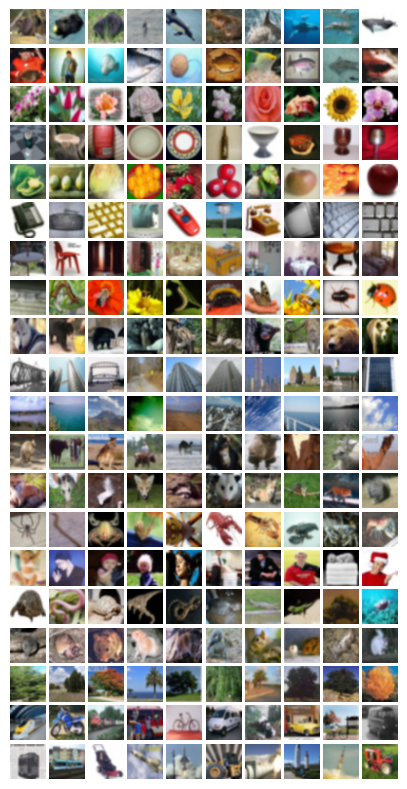

Test:


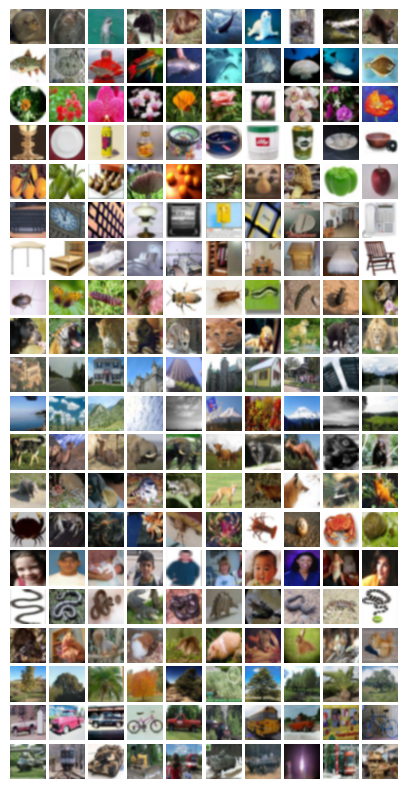

Train:
Class distribution: [1185. 1191. 1182. 1212. 1194. 1230. 1140. 1257. 1203. 1170. 1236. 1206.
 1164. 1203. 1215. 1173. 1188. 1176. 1233. 1242.]
Validate:
Class distribution: [105. 103. 106.  96. 102.  90. 120.  81.  99. 110.  88.  98. 112.  99.
  95. 109. 104. 108.  89.  86.]
Test:
Class distribution: [100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100.]


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the data
def load_data(folder):
    data = np.load(os.path.join(folder, 'data.npy'))
    labels = np.load(os.path.join(folder, 'labels.npy'))
    return data, labels

# Visualize the images
def visualize_images(data, labels, num_images_per_class):
    fig, axs = plt.subplots(20, num_images_per_class, figsize=(5, 10))  # 20 superclasses
    for i in range(20):  # For each superclass
        indices = np.where(np.argmax(labels, axis=1) == i)[0]
        random_indices = np.random.choice(indices, num_images_per_class, replace=False)
        for j, image_index in enumerate(random_indices):
            image = data[image_index]
            axs[i, j].imshow(image, interpolation='bicubic')
            axs[i, j].axis('off')  # Hide axes
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

# Check the class distribution
def check_class_distribution(labels):
    class_distribution = np.sum(labels, axis=0)
    print("Class distribution:", class_distribution)

# Load the data
data_train, label_train = load_data('../data/clean-all-cifar-100-python/train')
data_validate, label_validate = load_data('../data/clean-all-cifar-100-python/validate')
data_test, label_test = load_data('../data/clean-all-cifar-100-python/test')

# Visualize the validate images
print("Validate:")
visualize_images(data_validate, label_validate, 10)

# Visualize the test images
print("Test:")
visualize_images(data_test, label_test, 10)

# Check the class distribution
print("Train:")
check_class_distribution(label_train)
print("Validate:")
check_class_distribution(label_validate)
print("Test:")
check_class_distribution(label_test)

## Model Selection Process and Parameter Tuning

1. **Choose a model architecture**: For image classification tasks, convolutional neural networks (CNNs) are usually a good choice. We want to experiment with three different architectures (Xception, DenseNet201, DenseNet121) to see which one works best for this dataset.

2. **Hyperparameter tuning**: Tune the hyperparameters of our model (learning rate, batch size, number of layers) to optimize its performance.

3. **Regularization**: To prevent overfitting, We want to use regularization techniques like dropout.

4. **Model training**: Train our model using the train set and monitor its performance on the validation set. We can use techniques like early stopping to prevent overfitting.

5. **Model evaluation**: Evaluate the performance of our model on the test set using appropriate metrics (e.g., accuracy, precision, recall, F1 score).

### A) Model Architecture: Xception

0.0001
Epoch 1/10


2023-12-15 11:55:38.451584: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-12-15 11:55:39.722561: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-15 11:55:39.723062: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-15 11:55:39.723100: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-12-15 11:55:39.723739: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-15 11:55:39.723868: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


750/750 [==============================] - 22s 21ms/step - loss: 2.9957 - accuracy: 0.0508 - val_loss: 2.9963 - val_accuracy: 0.0575
Epoch 2/10
750/750 [==============================] - 14s 19ms/step - loss: 2.9955 - accuracy: 0.0560 - val_loss: 2.9961 - val_accuracy: 0.0670
Epoch 3/10
750/750 [==============================] - 15s 19ms/step - loss: 2.9953 - accuracy: 0.0596 - val_loss: 2.9960 - val_accuracy: 0.0580
Epoch 4/10
750/750 [==============================] - 15s 20ms/step - loss: 2.9951 - accuracy: 0.0546 - val_loss: 2.9954 - val_accuracy: 0.0810
Epoch 5/10
750/750 [==============================] - 15s 19ms/step - loss: 2.9949 - accuracy: 0.0610 - val_loss: 2.9952 - val_accuracy: 0.0860
Epoch 6/10
750/750 [==============================] - 15s 19ms/step - loss: 2.9947 - accuracy: 0.0599 - val_loss: 2.9949 - val_accuracy: 0.0630
Epoch 7/10
750/750 [==============================] - 15s 19ms/step - loss: 2.9946 - accuracy: 0.0577 - val_loss: 2.9944 - val_accuracy: 0.0740
Epo

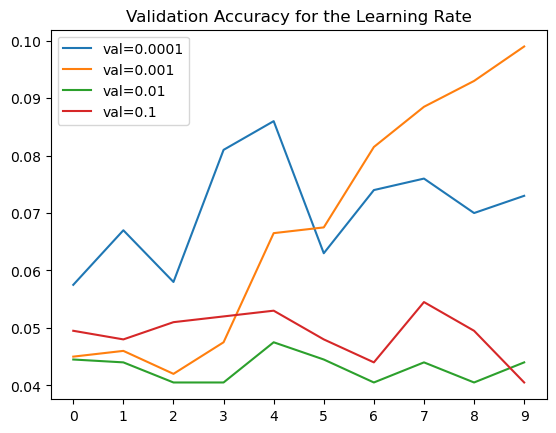

10
Epoch 1/10
750/750 [==============================] - 17s 21ms/step - loss: 2.9960 - accuracy: 0.0487 - val_loss: 2.9968 - val_accuracy: 0.0465
Epoch 2/10
750/750 [==============================] - 15s 20ms/step - loss: 2.9956 - accuracy: 0.0530 - val_loss: 2.9969 - val_accuracy: 0.0430
Epoch 3/10
750/750 [==============================] - 15s 20ms/step - loss: 2.9953 - accuracy: 0.0541 - val_loss: 2.9966 - val_accuracy: 0.0445
Epoch 4/10
750/750 [==============================] - 15s 20ms/step - loss: 2.9950 - accuracy: 0.0580 - val_loss: 2.9952 - val_accuracy: 0.0505
Epoch 5/10
750/750 [==============================] - 15s 20ms/step - loss: 2.9946 - accuracy: 0.0574 - val_loss: 2.9938 - val_accuracy: 0.0675
Epoch 6/10
750/750 [==============================] - 15s 20ms/step - loss: 2.9940 - accuracy: 0.0590 - val_loss: 2.9920 - val_accuracy: 0.0665
Epoch 7/10
750/750 [==============================] - 15s 20ms/step - loss: 2.9933 - accuracy: 0.0615 - val_loss: 2.9917 - val_accura

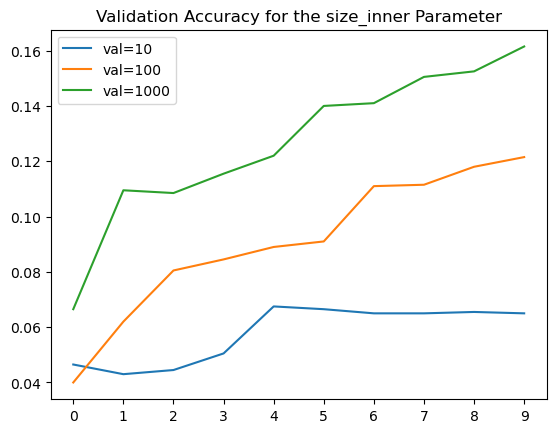

0.0
Epoch 1/10
750/750 [==============================] - 18s 21ms/step - loss: 2.9958 - accuracy: 0.0527 - val_loss: 2.9909 - val_accuracy: 0.0445
Epoch 2/10
750/750 [==============================] - 15s 20ms/step - loss: 2.9889 - accuracy: 0.0616 - val_loss: 2.9631 - val_accuracy: 0.0970
Epoch 3/10
750/750 [==============================] - 15s 20ms/step - loss: 2.9782 - accuracy: 0.0688 - val_loss: 2.9263 - val_accuracy: 0.1140
Epoch 4/10
750/750 [==============================] - 15s 20ms/step - loss: 2.9670 - accuracy: 0.0728 - val_loss: 2.9005 - val_accuracy: 0.1115
Epoch 5/10
750/750 [==============================] - 15s 20ms/step - loss: 2.9563 - accuracy: 0.0749 - val_loss: 2.8695 - val_accuracy: 0.1345
Epoch 6/10
750/750 [==============================] - 15s 20ms/step - loss: 2.9458 - accuracy: 0.0776 - val_loss: 2.8474 - val_accuracy: 0.1215
Epoch 7/10
750/750 [==============================] - 15s 20ms/step - loss: 2.9373 - accuracy: 0.0822 - val_loss: 2.8190 - val_accur

KeyboardInterrupt: 

In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# Load the data
def load_data(folder):
    data = np.load(os.path.join(folder, 'data.npy'))
    labels = np.load(os.path.join(folder, 'labels.npy'))
    return data, labels

# Define the model
def make_model(learning_rate=0.01, size_inner=10, droprate=0.0):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(75, 75, 3)  # Use the resized image size 75x75
    )
    base_model.trainable = False
    inputs = keras.Input(shape=(75, 75, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    vectors = Dropout(droprate)(vectors)  # Add dropout
    vectors = keras.layers.Dense(size_inner, activation='relu')(vectors)  # Adjust the size of inner layer
    outputs = keras.layers.Dense(20)(vectors)  # Use 20 superclasses
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    return model

# Load the data
data_train, label_train = load_data('../data/clean-all-cifar-100-python/train')
data_test, label_test = load_data('../data/clean-all-cifar-100-python/validate')

# Preprocess the data using the Xception preprocessing function
data_train = preprocess_input(data_train)
data_test = preprocess_input(data_test)

# Fine-tune the learning rate
best_val_accuracy = 0
best_lr = 0
scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)
    model = make_model(learning_rate=lr)
    history = model.fit(data_train, label_train, epochs=10, validation_data=(data_test, label_test))
    scores[lr] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_lr = lr

for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
plt.title('Validation Accuracy for the Learning Rate')
plt.xticks(np.arange(10))
plt.legend()
plt.show()

# Fine-tune the size_inner parameter
best_val_accuracy = 0
best_size = 0
scores = {}
for size in [10, 100, 1000]:
    print(size)
    model = make_model(learning_rate=best_lr, size_inner=size)
    history = model.fit(data_train, label_train, epochs=10, validation_data=(data_test, label_test))
    scores[size] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_size = size

for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))
plt.title('Validation Accuracy for the size_inner Parameter')
plt.xticks(np.arange(10))
plt.legend()
plt.show()
        
# Fine-tune the dropout rate
best_val_accuracy = 0
best_droprate = 0
scores = {}
for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)
    model = make_model(learning_rate=best_lr, size_inner=best_size, droprate=droprate)
    history = model.fit(data_train, label_train, epochs=10, validation_data=(data_test, label_test))
    scores[droprate] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_droprate = droprate

for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))
plt.title('Validation Accuracy for the Dropout Rate')
plt.xticks(np.arange(10))
plt.legend()
plt.show()
        
# Save the best model using callbacks and checkpointing
model = make_model(learning_rate=best_lr, size_inner=best_size, droprate=best_droprate)
checkpoint = ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
history = model.fit(
    data_train,
    label_train,
    epochs=10,
    validation_data=(data_test, label_test),
    callbacks=[checkpoint]
)

### B) Model Architecture: DenseNet121

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# Load the data
def load_data(folder):
    data = np.load(os.path.join(folder, 'data.npy'))
    labels = np.load(os.path.join(folder, 'labels.npy'))
    return data, labels

# Define the model
def make_model(learning_rate=0.01, size_inner=10, droprate=0.0):
    base_model = DenseNet121(  # Use DenseNet121
        weights='imagenet',
        include_top=False,
        input_shape=(75, 75, 3)  # Use the resized image size 75x75
    )
    base_model.trainable = False
    inputs = keras.Input(shape=(75, 75, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    vectors = Dropout(droprate)(vectors)  # Add dropout
    vectors = keras.layers.Dense(size_inner, activation='relu')(vectors)  # Adjust the size of inner layer
    outputs = keras.layers.Dense(20)(vectors)  # Use 20 superclasses
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    return model

# Load the data
data_train, label_train = load_data('../data/clean-all-cifar-100-python/train')
data_test, label_test = load_data('../data/clean-all-cifar-100-python/validate')

# Preprocess the data using the densenet preprocessing function
data_train = preprocess_input(data_train)
data_test = preprocess_input(data_test)

# Fine-tune the learning rate
best_val_accuracy = 0
best_lr = 0
scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)
    model = make_model(learning_rate=lr)
    history = model.fit(data_train, label_train, epochs=50, validation_data=(data_test, label_test))
    scores[lr] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_lr = lr

for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
plt.title('Validation Accuracy for the Learning Rate')
plt.xticks(np.arange(10))
plt.legend()
plt.show()

# Fine-tune the size_inner parameter
best_val_accuracy = 0
best_size = 0
scores = {}
for size in [10, 100, 1000]:
    print(size)
    model = make_model(learning_rate=best_lr, size_inner=size)
    history = model.fit(data_train, label_train, epochs=50, validation_data=(data_test, label_test))
    scores[size] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_size = size

for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))
plt.title('Validation Accuracy for the size_inner Parameter')
plt.xticks(np.arange(10))
plt.legend()
plt.show()
        
# Fine-tune the dropout rate
best_val_accuracy = 0
best_droprate = 0
scores = {}
for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)
    model = make_model(learning_rate=best_lr, size_inner=best_size, droprate=droprate)
    history = model.fit(data_train, label_train, epochs=50, validation_data=(data_test, label_test))
    scores[droprate] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_droprate = droprate

for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))
plt.title('Validation Accuracy for the Dropout Rate')
plt.xticks(np.arange(10))
plt.legend()
plt.show()

# Save the best model using callbacks and checkpointing
model = make_model(learning_rate=best_lr, size_inner=best_size, droprate=best_droprate)
checkpoint = ModelCheckpoint(
    'densenet121_v1_{epoch:02d}_{val_accuracy:.3f}.h5',  # Change the filename to reflect the use of DenseNet121
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
history = model.fit(
    data_train,
    label_train,
    epochs=50,
    validation_data=(data_test, label_test),
    callbacks=[checkpoint]
)

2023-12-15 12:17:50.761010: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


0.0001


2023-12-15 12:18:07.937920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-15 12:18:07.961014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-15 12:18:07.961588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-15 12:18:07.962399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Epoch 1/50


2023-12-15 12:18:19.839003: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-12-15 12:18:21.121184: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-15 12:18:21.121653: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-15 12:18:21.121688: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-12-15 12:18:21.122190: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-15 12:18:21.122280: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


750/750 [==============================] - 25s 20ms/step - loss: 3.0020 - accuracy: 0.0521 - val_loss: 2.9949 - val_accuracy: 0.0485
Epoch 2/50
750/750 [==============================] - 13s 17ms/step - loss: 2.9954 - accuracy: 0.0488 - val_loss: 2.9950 - val_accuracy: 0.0450
Epoch 3/50
750/750 [==============================] - 13s 17ms/step - loss: 2.9952 - accuracy: 0.0515 - val_loss: 2.9948 - val_accuracy: 0.0525
Epoch 4/50
750/750 [==============================] - 13s 17ms/step - loss: 2.9947 - accuracy: 0.0527 - val_loss: 2.9932 - val_accuracy: 0.0445
Epoch 5/50
750/750 [==============================] - 13s 17ms/step - loss: 2.9946 - accuracy: 0.0500 - val_loss: 2.9930 - val_accuracy: 0.0470
Epoch 6/50
750/750 [==============================] - 13s 17ms/step - loss: 2.9939 - accuracy: 0.0536 - val_loss: 2.9936 - val_accuracy: 0.0530
Epoch 7/50
750/750 [==============================] - 13s 17ms/step - loss: 2.9933 - accuracy: 0.0543 - val_loss: 2.9908 - val_accuracy: 0.0505
Epo

KeyboardInterrupt: 

### C) Best Model Comparison

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load the data
def load_data(folder):
    data = np.load(os.path.join(folder, 'data.npy'))
    labels = np.load(os.path.join(folder, 'labels.npy'))
    return data, labels

# Load the test data
data_test, label_test = load_data('../data/clean-all-cifar-100-python/test')

# Define the model names
model_names = ['xception_v1_09_0.558.h5', 
               'resnet50_v1_10_0.138.h5', 
               'densenet121_v1_34_0.592.h5']

# Initialize a dictionary to store the metrics
metrics = {}

# For each model
for model_name in model_names:
    # Load the model
    model = load_model(model_name)
    # Evaluate the model
    loss, accuracy = model.evaluate(data_test, label_test, verbose=0)
    # Predict the classes
    y_pred = model.predict(data_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(label_test, axis=1)
    # Calculate precision, recall, and F1 score
    classification_metrics = classification_report(y_true_classes, y_pred_classes, output_dict=True)
    precision = classification_metrics['weighted avg']['precision']
    recall = classification_metrics['weighted avg']['recall']
    f1_score = classification_metrics['weighted avg']['f1-score']
    # Store the metrics
    metrics[model_name] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score}

# Plot the metrics
plt.figure(figsize=(10, 6))
for model_name, model_metrics in metrics.items():
    plt.plot(list(model_metrics.values()), label=model_name)
plt.xticks(np.arange(4), ['accuracy', 'precision', 'recall', 'f1_score'])
plt.legend()
plt.show()

### D) Final Model Selection

In [ ]:
# The name of the best model based on the Best Model Comparison
print("densenet121_v1_34_0.592.h5")